# Определение перспективного тарифа для телеком-компании

В компании «Мегалайн» — федерального оператора сотовой связи клиентам предлагают два тарифных плана: «Смарт» и «Ультра».

Чтобы скорректировать рекламный бюджет необходимо определить, какой тариф приносит больше денег.

**Цель**

Необходимо сделать предварительный анализ тарифов для пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

**Задача**

Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше. 

## Изучение данных из файлов

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.histograms import histogram
from scipy import stats as st
import math
  
df_users = pd.read_csv('/datasets/users.csv')
display(df_users.head())
df_users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Пропусков в нанных нет кроме столбца churn_date, раз нет значения окончатия тарифа значит им еще пользуются, менять не будем.


In [2]:
df_calls = pd.read_csv('/datasets/calls.csv')
display(df_calls.head())
df_calls.info()
df_calls['duration'].sort_values()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


0          0.00
57375      0.00
57380      0.00
57381      0.00
157627     0.00
          ...  
60889     35.95
39777     36.12
5865      36.47
178737    37.35
95088     38.00
Name: duration, Length: 202607, dtype: float64

Хорошо что нет пропусков и название столбца user_id совподает с кодом пользователя из таблицы пользователей, это упростит дальнейшую обработку

In [3]:
df_internet = pd.read_csv('/datasets/internet.csv')
display(df_internet.head())
df_internet.info()
df_internet['mb_used'].sort_values()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


116616       0.00
53410        0.00
104303       0.00
19438        0.00
19437        0.00
           ...   
140299    1623.92
103480    1651.25
7063      1651.55
119156    1702.75
137493    1724.83
Name: mb_used, Length: 149396, dtype: float64

Также нет пропусков и user_id на месте, а вот столбец Unnamed: 0 не понятно о чем говорит, может это повторение индексов?

Проверим


In [4]:
df_internet['Unnamed: 0'].unique()

array([     0,      1,      2, ..., 149393, 149394, 149395])

Так и есть, можно от него избавиться

In [5]:
df_internet.drop(columns = ['Unnamed: 0'],axis = 1, inplace=True)
df_internet

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


In [6]:
df_messages = pd.read_csv('/datasets/messages.csv')
display(df_messages.head())
df_messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Здесь тоже все хорошо, пропусков нет и user_id на месте

In [7]:
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
# Столбец tariff_name переименуем на tariff как в таблице с пользователями для дальнейшено объединения
df_tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included'
                      , 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff']
display(df_tariffs.head())
df_tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff                   2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


### Вывод

Для дальнейшего анализа надо будет колонки с датами преобразовать в формат даты и конечно придется делать объединение таблиц

## Предобработка данных

Преобразуем колонки с датами в формат даты

 Приведем столбцы с датами к формату дат

In [8]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')


Посчитаем количество звонков и израсходованных минут по месячно

In [9]:
df_calls['month'] = df_calls['call_date'].astype('datetime64[M]')
df_calls['duration'] = np.ceil(df_calls['duration'])
display(df_calls['duration'])
df_calls_grouped = df_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum']).reset_index()
df_calls_grouped.columns = (['user_id', 'month', 'calls_count', 'duration_sum'])
df_calls_grouped['duration_sum'] = df_calls_grouped['duration_sum'].astype('int')
df_calls_grouped.head()

0          0.0
1          0.0
2          3.0
3         14.0
4          6.0
          ... 
202602     1.0
202603    19.0
202604    11.0
202605     5.0
202606    20.0
Name: duration, Length: 202607, dtype: float64

,user_id,month,calls_count,duration_sum
0,1000,2018-05-01,22,159
1,1000,2018-06-01,43,172
2,1000,2018-07-01,47,340
3,1000,2018-08-01,52,408
4,1000,2018-09-01,58,466


Так же посчитаем количество сообщений по месячно

In [10]:
df_messages['month'] = df_messages['message_date'].astype('datetime64[M]')
df_messages_grouped = df_messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count').reset_index()
df_messages_grouped.columns = (['user_id', 'month', 'messages_count'])
df_messages_grouped

,user_id,month,messages_count
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57
...,...,...,...
2712,1498,2018-10-01,42
2713,1499,2018-09-01,11
2714,1499,2018-10-01,48
2715,1499,2018-11-01,59


Так же посчитаем количество трафика по месячно

In [11]:
df_internet['month'] = df_internet['session_date'].astype('datetime64[M]')
df_internet_grouped = df_internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()
df_internet_grouped['mb_used'] = np.ceil(df_internet_grouped['mb_used'])
df_internet_grouped['mb_used'] = df_internet_grouped['mb_used']/1024
df_internet_grouped['mb_used'] = df_internet_grouped['mb_used'].astype('int')
df_internet_grouped

,user_id,month,mb_used
0,1000,2018-05-01,2
1,1000,2018-06-01,22
2,1000,2018-07-01,13
3,1000,2018-08-01,13
4,1000,2018-09-01,14
...,...,...,...
3198,1498,2018-10-01,20
3199,1499,2018-09-01,1
3200,1499,2018-10-01,17
3201,1499,2018-11-01,17


Объединим данные в одну таблицу

In [12]:
df = df_users.merge(df_calls_grouped, on='user_id', how='outer')
df = df.merge(df_messages_grouped, on=['user_id', 'month'], how='outer')
df = df.merge(df_internet_grouped, on=['user_id', 'month'], how='outer')
df = df.merge(df_tariffs, on=['tariff'], how='left')
df

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,calls_count,duration_sum,messages_count,mb_used,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-01,22.0,159.0,22.0,2.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0
1,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-06-01,43.0,172.0,60.0,22.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0
2,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-07-01,47.0,340.0,75.0,13.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0
3,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-08-01,52.0,408.0,81.0,13.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0
4,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-09-01,58.0,466.0,57.0,14.0,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3217,1489,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2018-09-01,NaN,NaN,32.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3218,1489,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2018-10-01,NaN,NaN,21.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3219,1489,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2018-11-01,NaN,NaN,20.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3220,1489,NaN,NaN,NaN,NaN,NaN,NaT,NaN,2018-12-01,NaN,NaN,35.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Теперь посчитаем выручку от каждого пользователя

In [13]:
# фунция подсчета выручки
def revenue(row):
    sms = (row['messages_count'] - row['messages_included'])*row['rub_per_message']
    mins = (row['duration_sum'] - row['minutes_included'])*row['rub_per_minute']
    gbs = (row['mb_used'] - row['mb_per_month_included'])/ 1024
    gbs = np.ceil(gbs) * row['rub_per_gb']
    
    total = 0
    if sms>0:
        total += sms
    if mins>0:
        total += mins
    if gbs>0:
        total += gbs
    total += row['rub_monthly_fee']
    return total
df['revenue'] = df.apply(revenue,axis = 1)
df['revenue']

0       1950.0
1       1950.0
2       1950.0
3       1950.0
4       1950.0
         ...  
3217       NaN
3218       NaN
3219       NaN
3220       NaN
3221       NaN
Name: revenue, Length: 3222, dtype: float64

## Анализ данных

Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 

Посчить среднее количество, дисперсию и стандартное отклонение.

Постройть гистограммы.
Описать распределения.

,duration_mean,duration_var,duration_std
tariff,,,
smart,419.06,35844.19,189.33
ultra,545.45,94203.42,306.93


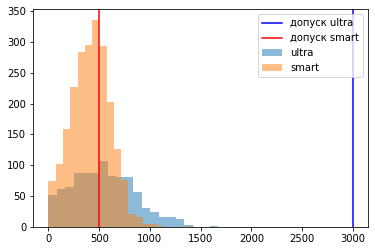

In [14]:
duration_pivot = df.pivot_table(index= 'tariff', values= 'duration_sum', aggfunc= ['mean', 'var','std']).round(2)
duration_pivot.columns=['duration_mean', 'duration_var', 'duration_std']
display(duration_pivot)
plt.hist(df[df['tariff'] == 'ultra']['duration_sum'], bins=20, alpha=0.5, label='ultra')
plt.axvline(x = 3000, color = 'b', label = 'допуск ultra')
plt.hist(df[df['tariff'] == 'smart']['duration_sum'], bins=20, alpha=0.5, label='smart')
plt.axvline(x = 500, color = 'r', label = 'допуск smart')
plt.legend(loc='upper right')



Оба распределения близки к нормальному. Средние значения тоже близки. У тарифа ultra дисперсия гораздо выше тарифа smart и больше отклонение от среднего.

В тарифе smart много превышений включенного в тариф количества минут.

,messages_mean,messages_var,messages_std
tariff,,,
smart,38.75,719.17,26.82
ultra,61.20,1999.57,44.72


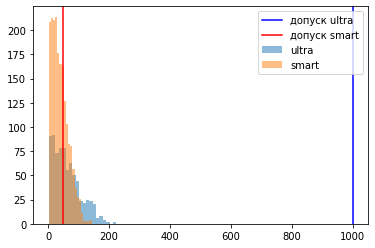

In [15]:
messages_pivot = df.pivot_table(index= 'tariff', values= 'messages_count', aggfunc= ['mean', 'var','std']).round(2)
messages_pivot.columns=['messages_mean', 'messages_var', 'messages_std']
display(messages_pivot)
plt.hist(df[df['tariff'] == 'ultra']['messages_count'], bins=20, alpha=0.5, label='ultra')
plt.axvline(x = 1000, color = 'b', label = 'допуск ultra')
plt.hist(df[df['tariff'] == 'smart']['messages_count'], bins=20, alpha=0.5, label='smart')
plt.axvline(x = 50, color = 'r', label = 'допуск smart')
plt.legend(loc='upper right')


Оба распределения положительно скошены. У тарифа ultra дисперсия также гораздо выше тарифа smart и отклонения тоже больше чем у тарифа smart.
Также много пользователей превышают включенный лимит сообщений

,mb_mean,mb_var,mb_std
tariff,,,
smart,15.34,32.99,5.74
ultra,18.70,94.75,9.73


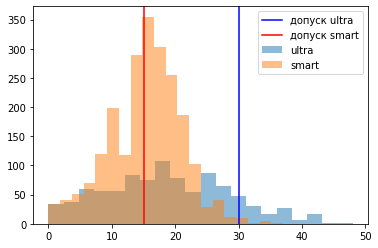

In [16]:
mb_pivot = df.pivot_table(index= 'tariff', values= 'mb_used', aggfunc= ['mean', 'var','std']).round(2)
mb_pivot.columns=['mb_mean', 'mb_var', 'mb_std']
display(mb_pivot)
plt.hist(df[df['tariff'] == 'ultra']['mb_used'], bins=20, alpha=0.5, label='ultra')
plt.axvline(x = 30, color = 'b', label = 'допуск ultra')
plt.hist(df[df['tariff'] == 'smart']['mb_used'], bins=20, alpha=0.5, label='smart')
plt.axvline(x = 15, color = 'r', label = 'допуск smart')
plt.legend(loc='upper right')


Распределения близкие к нормальному. Как и со звонками и смс у тарифа ultra дисперсия и среднее отклонение также гораздо выше тарифа smart. Среднее количество трафика в тарифе smart гораздо выше.

Пользователям тарифа smart маловато трафика включенного в тариф, много превышений.

## Проверка гипотезы

средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.



tariff
smart    1540751.0
ultra    1866150.0
Name: revenue, dtype: float64


,mean,var,std
,revenue,revenue,revenue
tariff,,,
smart,692.47,68217.34,261.18
ultra,1950.00,0.00,0.00


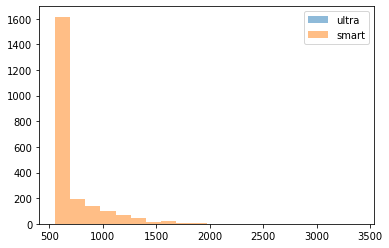

In [17]:
plt.hist(df[df['tariff'] == 'ultra']['revenue'], bins=20, alpha=0.5, label='ultra')
plt.hist(df[df['tariff'] == 'smart']['revenue'], bins=20, alpha=0.5, label='smart')
plt.legend(loc='upper right')
# расчитаем сренее, , дисперсию и отклонение
var_revenue = df.pivot_table(index= 'tariff', values= 'revenue', aggfunc= ['mean', 'var','std']).round(2)
print(df.groupby('tariff')['revenue'].sum()) #посчитаем общую выручку по тарифам
var_revenue

Общая выручка тарифов схожа, а вот средняя выручка отличается

Проверим гипотезу что средняя выручка тарифов одинакова. Альтернативной гипотезой будет не равенство вывручки.

Проверку проведем двусторонним t-тестом, критический уровень статистической значимости выберим 5%

In [18]:
smart = df[df['tariff']=='smart']['revenue'] 
ultra = df[df['tariff']=='ultra']['revenue'] 
 
alpha = 0.05
results = st.ttest_ind(smart, ultra, equal_var = False)
 
print('p-значение: ', results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 


p-значение:  0.0
Отвергаем нулевую гипотезу


Гипотеза что средние выручки тарифов равны не верная.


Теперь сравним выручку по тарифам в Москве и в других регионах.

Тем же методом и с такими же гипотезами.

In [19]:
moskow = df[df['city']=='Москва']['revenue'].dropna()
not_moskow = df[df['city']!='Москва']['revenue'].dropna()
alpha = 0.05
results = st.ttest_ind(moskow, not_moskow, equal_var = False)
print('средняя выручка в Москве:', moskow.mean())
print('средняя выручка в других регионах:', not_moskow.mean())
print('p-значение: ', results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

средняя выручка в Москве: 1146.544262295082
средняя выручка в других регионах: 1052.6862363919129
p-значение:  0.0010660098332554646
Отвергаем нулевую гипотезу


Средняя выручка в Москве равна средней выручке в других регионах

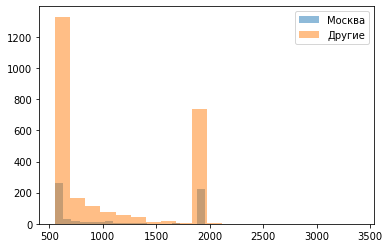

In [20]:
plt.hist(df[df['city'] == 'Москва']['revenue'], bins=20, alpha=0.5, label='Москва')
plt.hist(df[df['city'] != 'Москва']['revenue'], bins=20, alpha=0.5, label='Другие')
plt.legend(loc='upper right')

## Общий вывод

Вывд:
В тарифе smart больше коротких звонков и меньше сообщений. Расходование интернет трафика близки в тарифах.
- Среднее количество звонков в тарифе smart 419 а в тарифе ultra 545. Отличие не большое, но больше половины пользователей тарифа smart превышают включенные в тариф количество минут.
- Среднее количество сообщений в тарифе smart 38 а в тарифе ultra 61. Есть различие. Как и с минутами пользователи тарифа smart превышают включенные в тариф количество сообщений, а тарифа ultra не используют предоставленные сообщения.
- Среднее количество использованого трафика интернета в тарифе smart 16237 а в тарифе ultra 19687. Есть небольшое различие. Также пользователи тарифа smart превышают включенные в тариф количество трафика, а пользователи тарифа ultra не часть превышают лимит.

Общая выручка у тарифов примерно одинатовая хотя средняя выручка в месяц гораздо выше у тарифа ultra.
Среднияя выручка тарифа smart 1294 а тарифа ultra выше 2071. Сравнивая выручку в Москве и в других регионах примерно одинаковые. Значит регион не влияет на среднюю выручку по тарифам.

**В итоге можно сделать вывод что тариф ultra лучше тарифа smart так как пользователи не будут превышать установленный лимит звонков сообщений и трафика. А если учесть что средняя выручка тарифа ultra выше то и для компании «Мегалайн» выгодно рекламировать этот тариф активнее.**
